In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dropout





# **Exploratory Data Analysis (EDA)**

In [ ]:
# Load the dataset
file_path = 'cleaned_electricity_data.csv'
df = pd.read_csv(file_path)
print(df.head())

                            CONS_NO  FLAG  2014/1/1  2014/1/10  2014/1/11  \
0  0387DD8A07E07FDA6271170F86AD9151     1       0.0       0.00       0.00   
1  01D6177B5D4FFE0CABA9EF17DAFC2B84     1       0.0       0.00       0.00   
2  4B75AC4F2D8434CFF62DB64D0BB43103     1       0.0       0.00       0.00   
3  B32AC8CC6D5D805AC053557AB05F5343     1       0.0       0.00       0.00   
4  EDFC78B07BA2908B3395C4EB2304665E     1       2.9       3.42       3.81   

   2014/1/12  2014/1/13  2014/1/14  2014/1/15  2014/1/16  ...  2016/9/29  \
0       0.00       0.00       0.00       0.00       0.00  ...       9.96   
1       0.00       0.00       0.00       0.00       0.00  ...       0.00   
2       0.00       0.00       0.00       0.00       0.00  ...       0.00   
3       0.00       0.00       0.00       0.00       0.00  ...       9.99   
4       4.58       3.56       4.25       3.86       3.53  ...      10.37   

   2016/9/3  2016/9/30  2016/9/4  2016/9/5  2016/9/6  2016/9/7  2016/9/8  \
0   

# **Preprocessing**

In [ ]:
# Separate features and labels
X = df.iloc[:, 2:-1]  # all columns except the 'FLAG' and 'CONSUMER_ID'
y = df['FLAG']        # the anomaly flag column


In [ ]:
# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X_scaled)

# Verify PCA explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Explained Variance by 100 components:", explained_variance)
if explained_variance < 0.9:
    print(f"Warning: PCA retains only {explained_variance:.2%} of the variance. Consider increasing n_components.")

# Generate sequences for LSTM
time_steps = 30
X_sequences = np.array([X_reduced[i - time_steps:i, :] for i in range(time_steps, X_reduced.shape[0])])
y_sequences = np.array(y[time_steps:])

# Validate shapes
print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)

assert len(X) == len(y), "X and y must have the same number of rows"
print("Data alignment verified.")


Explained Variance by 100 components: 0.9792467067984526
X_sequences shape: (42337, 30, 100)
y_sequences shape: (42337,)
Data alignment verified.


I normalized the data to ensure all the features are on same scale.  

Applied PCA to reduce dimensionality and making the data more managable for modeling,  while retaining variance of 98%.

The sequence generation is done to format the data for LSTM  input for capturing temporal patterns in the data.

# **LSTM Training for features**

In [ ]:
# Define the LSTM model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_sequences.shape[1], X_sequences.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='mse')
model.fit(X_sequences, y_sequences, epochs=15, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 1.4714 - val_loss: 1.0066
Epoch 2/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.9920 - val_loss: 0.6657
Epoch 3/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.6825 - val_loss: 0.4376
Epoch 4/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.4790 - val_loss: 0.2912
Epoch 5/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.3429 - val_loss: 0.2027
Epoch 6/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.2465 - val_loss: 0.1307
Epoch 7/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 0.1757 - val_loss: 0.0981
Epoch 8/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.1345 - val_loss: 0.0647
Epoch 9/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - loss: 0.1091 - val_loss: 0.0478
Epoch 10/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0932 - val_loss: 0.0582
Epoch 11/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0820 - val_loss: 0.0424
Epoch 12

# **Feature Extraction**

In [ ]:
# Extract features by getting the output of the last Dense layer
feature_extractor = Sequential(model.layers[:-2])
X_features = feature_extractor.predict(X_sequences)


print("Extracted Features Shape:", X_features.shape)


1324/1324 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
Extracted Features Shape: (42337, 50)


The trained LSTM model is used to extract high-level temporal features (X_features) from the input sequences, which are then used for training the Random Forest Classifier for anamoly detection.


# **Training Random Forest Classifier**

In [ ]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [ ]:
# model: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight={0: 1, 1: 20} )
rf_model.fit(X_train_resampled, y_train_resampled)


# **Evaluation**

In [ ]:
y_pred = rf_model.predict(X_test)
print("\nConfusion Matrix (RandomForest):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (RandomForest):")
print(classification_report(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix (RandomForest):
[[7595  157]
 [  75  641]]

Classification Report (RandomForest):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7752
           1       0.80      0.90      0.85       716

    accuracy                           0.97      8468
   macro avg       0.90      0.94      0.92      8468
weighted avg       0.97      0.97      0.97      8468


Accuracy: 0.9726027397260274


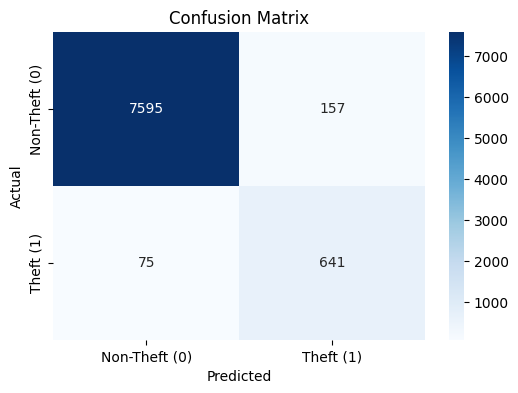

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Theft (0)', 'Theft (1)']

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


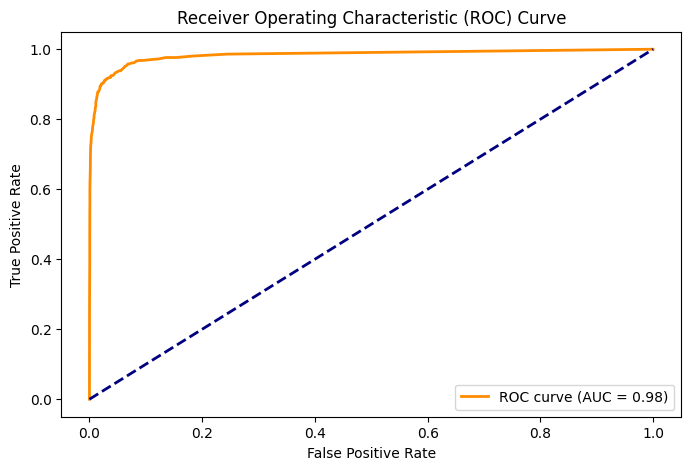

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
